In [1]:
from pypendula import PyPendula

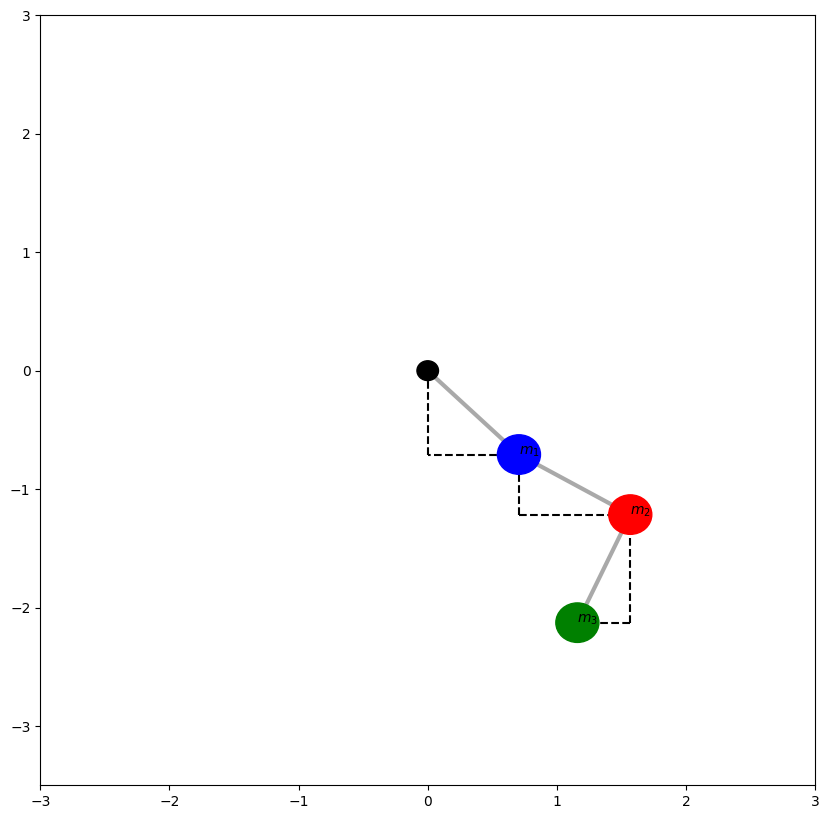

In [2]:
pendula = PyPendula()
fig = pendula.show_diagram()

In [1]:
import sympy as sp
import numpy as np
from sympy.physics.mechanics import dynamicsymbols, LagrangesMethod
from sympy.matrices import Matrix
from scipy.integrate import solve_ivp
from functools import partial
import dill

rng = np.random.default_rng()

#### $n=1$

In [2]:
ics = [0.1, 0.0]
t_f = 15
t_eval = np.linspace(0, t_f, 100)
params = {'m' : 1, 'g' : 10, 'l' : 1}

q = dynamicsymbols(f'q')
p = dynamicsymbols(f'q', level=1)
dp = dynamicsymbols(f'q', level=2)
l, m, g, t = sp.symbols('l m g t')

x, y =      l * sp.sin(q),    - l * sp.cos(q)
v_sqr = x.diff(t) ** 2 + y.diff(t) ** 2
kinetic = sp.Rational(1, 2) * m * v_sqr
potential = - m * g * y

lagrangian = kinetic - potential
lagranges_method = LagrangesMethod(lagrangian, [q])
euler_lagrange_eqns = lagranges_method.form_lagranges_equations()
eom = lagranges_method.eom

symbolic_dp = sp.solve(eom[0], dp)[0]
# ddq = (-g / l) * sp.sin(q)

numerical_dp = sp.utilities.lambdify([t, 
                                       [q, p], 
                                       m, g, l], 
                                      [p, symbolic_dp])
n_dp = partial(numerical_dp, **params)
dill.dump(n_dp, open(f"./cache/pypendula_cached_soln_n1", "wb"))
solve_ivp(n_dp, [0, t_f], ics, t_eval=t_eval)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.515e-01 ...  1.485e+01  1.500e+01]
        y: [[ 1.000e-01  1.117e-01 ... -2.843e+01 -2.935e+01]
            [ 0.000e+00  1.571e-01 ... -6.443e+00 -5.579e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 350
     njev: 0
      nlu: 0

#### $n=2$

In [3]:
ics = [0.1, -0.1, 0.0, 0.0]

q = dynamicsymbols(f'q:2')
dq = dynamicsymbols(f'q:2', level=1)
ddq = dynamicsymbols(f'q:2', level=2)
p = dynamicsymbols(f'p:2')
dp = dynamicsymbols(f'p:2', level=1)

x1, y1 =      l * sp.sin(q[0]),    - l * sp.cos(q[0])
x2, y2 = x1 + l * sp.sin(q[1]), y1 - l * sp.cos(q[1])

v1_sqr = x1.diff(t) ** 2 + y1.diff(t) ** 2
v2_sqr = x2.diff(t) ** 2 + y2.diff(t) ** 2

kinetic = sp.Rational(1, 2) * m * v1_sqr + sp.Rational(1, 2) * m * v2_sqr
potential = - m * g * y1 - m * g * y2

lagrangian = kinetic - potential
lagranges_method = LagrangesMethod(lagrangian, q)
euler_lagrange_eqns = lagranges_method.form_lagranges_equations()
eom = sp.simplify(lagranges_method.eom.subs([(dq[_], p[_]) for _ in range(2)]))

symbolic_dp = Matrix(list(sp.solve(eom, *dp).values()))

numerical_dp = sp.utilities.lambdify([t, 
                                       [*q, *p], 
                                       m, g, l], 
                                      [*p, *symbolic_dp])
n_dp = partial(numerical_dp, **params)
dill.dump(n_dp, open(f"./cache/pypendula_cached_soln_n2", "wb"))
# n_dp(0, ics)
solve_ivp(n_dp, [0, t_f], ics, t_eval=t_eval)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.515e-01 ...  1.485e+01  1.500e+01]
        y: [[ 1.000e-01  1.344e-01 ...  2.632e+01  2.742e+01]
            [-1.000e-01 -1.458e-01 ... -2.949e+01 -3.070e+01]
            [ 0.000e+00  4.741e-01 ...  6.396e+00  6.038e+00]
            [ 0.000e+00 -6.329e-01 ... -8.150e+00 -4.515e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1268
     njev: 0
      nlu: 0

#### $n=N$

In [7]:
N = 3

ALPHA = 3
ics_q = rng.uniform(-np.pi / ALPHA, np.pi / ALPHA, size=N)
ics_p = np.zeros(N)
ics = np.hstack([ics_q, ics_p])

q = dynamicsymbols(f'q:{N}')
dq = dynamicsymbols(f'q:{N}', level=1)
ddq = dynamicsymbols(f'q:{N}', level=2)
p = dynamicsymbols(f'p:{N}')
dp = dynamicsymbols(f'p:{N}', level=1)

###################
x, y = [l * sp.sin(q[0])], [- l * sp.cos(q[0])]
for i in range(1, N):
    x.append(x[i - 1] + l * sp.sin(q[i]))
    y.append(y[i - 1] - l * sp.cos(q[i]))
    
v_sqr = Matrix([_x.diff(t) ** 2 + _y.diff(t) ** 2 for _x,_y in zip(x, y)])
x, y = Matrix(x), Matrix(y)
####################

potential = -m * g * sum(y)
kinetic = sp.Rational(1, 2) * m * sum(v_sqr)
lagrangian = kinetic - potential
lagranges_method = LagrangesMethod(lagrangian, q)
euler_lagrange_eqns = lagranges_method.form_lagranges_equations()
eom = sp.simplify(lagranges_method.eom.subs([(dq[_], p[_]) for _ in range(N)]))

symbolic_dp = Matrix(list(sp.solve(eom, *dp).values()))

numerical_dp = sp.utilities.lambdify([t, 
                                       [*q, *p], 
                                       m, g, l], 
                                      [*p, *symbolic_dp])
n_dp = partial(numerical_dp, **params)
dill.dump(n_dp, open(f"./cache/pypendula_cached_soln_n{N}", "wb"))

solve_ivp(n_dp, [0, t_f], ics, t_eval=t_eval)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.515e-01 ...  1.485e+01  1.500e+01]
        y: [[ 3.903e-01  4.442e-01 ...  2.888e+01  2.813e+01]
            [-9.430e-01 -1.047e+00 ...  2.772e+01  2.814e+01]
            ...
            [ 0.000e+00 -1.354e+00 ...  5.069e+00  2.264e+00]
            [ 0.000e+00  8.037e-02 ...  1.036e+01  1.774e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1616
     njev: 0
      nlu: 0

In [2]:
pendula1 = PyPendula(N=3, gravity=1)
pendula1.solve_symbolic()
pendula1.eom

Matrix([[sin(q(t)) + Derivative(q(t), (t, 2))]])

In [3]:
pendula1.ddq

Matrix([[-sin(q(t))]])

In [4]:
pendula2 = PyPendula(N=2, gravity=1, reduce=True)
pendula2.eom

Matrix([
[ sin(q0(t) - q1(t))*Derivative(q1(t), t)**2/8 + sin(q0(t))/4 + cos(q0(t) - q1(t))*Derivative(q1(t), (t, 2))/8 + Derivative(q0(t), (t, 2))/4],
[-sin(q0(t) - q1(t))*Derivative(q0(t), t)**2/8 + sin(q1(t))/4 + cos(q0(t) - q1(t))*Derivative(q0(t), (t, 2))/8 + Derivative(q1(t), (t, 2))/8]])

In [5]:
pendula2.ddq

Matrix([
[-sin(q0(t) - q1(t))*Derivative(q1(t), t)**2/2 - sin(q0(t)) - cos(q0(t) - q1(t))*Derivative(q1(t), (t, 2))/2],
[   sin(q0(t) - q1(t))*Derivative(q0(t), t)**2 - 2*sin(q1(t)) - cos(q0(t) - q1(t))*Derivative(q0(t), (t, 2))]])

In [6]:
pendula3 = PyPendula(N=3, gravity=1, reduce=True)
pendula3.eom

Matrix([
[    2*sin(q0(t) - q1(t))*Derivative(q1(t), t)**2/27 + sin(q0(t) - q2(t))*Derivative(q2(t), t)**2/27 + sin(q0(t))/9 + 2*cos(q0(t) - q1(t))*Derivative(q1(t), (t, 2))/27 + cos(q0(t) - q2(t))*Derivative(q2(t), (t, 2))/27 + Derivative(q0(t), (t, 2))/9],
[-2*sin(q0(t) - q1(t))*Derivative(q0(t), t)**2/27 + sin(q1(t) - q2(t))*Derivative(q2(t), t)**2/27 + sin(q1(t))/9 + 2*cos(q0(t) - q1(t))*Derivative(q0(t), (t, 2))/27 + cos(q1(t) - q2(t))*Derivative(q2(t), (t, 2))/27 + 2*Derivative(q1(t), (t, 2))/27],
[      -sin(q0(t) - q2(t))*Derivative(q0(t), t)**2/27 - sin(q1(t) - q2(t))*Derivative(q1(t), t)**2/27 + sin(q2(t))/9 + cos(q0(t) - q2(t))*Derivative(q0(t), (t, 2))/27 + cos(q1(t) - q2(t))*Derivative(q1(t), (t, 2))/27 + Derivative(q2(t), (t, 2))/27]])

In [7]:
pendula3.ddq

Matrix([
[-2*sin(q0(t) - q1(t))*Derivative(q1(t), t)**2/3 - sin(q0(t) - q2(t))*Derivative(q2(t), t)**2/3 - sin(q0(t)) - 2*cos(q0(t) - q1(t))*Derivative(q1(t), (t, 2))/3 - cos(q0(t) - q2(t))*Derivative(q2(t), (t, 2))/3],
[     sin(q0(t) - q1(t))*Derivative(q0(t), t)**2 - sin(q1(t) - q2(t))*Derivative(q2(t), t)**2/2 - 3*sin(q1(t))/2 - cos(q0(t) - q1(t))*Derivative(q0(t), (t, 2)) - cos(q1(t) - q2(t))*Derivative(q2(t), (t, 2))/2],
[           sin(q0(t) - q2(t))*Derivative(q0(t), t)**2 + sin(q1(t) - q2(t))*Derivative(q1(t), t)**2 - 3*sin(q2(t)) - cos(q0(t) - q2(t))*Derivative(q0(t), (t, 2)) - cos(q1(t) - q2(t))*Derivative(q1(t), (t, 2))]])

In [ ]:
import dill
import numpy as np
from functools import partial
from scipy.integrate import solve_ivp


ICS = np.array([
    np.pi / 2, np.pi / 3, np.pi / 4,
    np.pi / 16, -np.pi / 16, np.pi / 16
])

SIM_PARAMS = {
    'fps': 30,
    'tf': 10
}

PARAMS = {
    'l_0': 1,
    'l_1': 1,
    'l_2': 1,

    'm_0': 1,
    'm_1': 1,
    'm_2': 1,

    'g': 10,
}

def solve_numeric(N=3, ics=ICS, params=PARAMS, sim_params=SIM_PARAMS, verbose=True):
    symbolic_soln = solve_symbolic(verbose=verbose, N=N)
    ODEsystem, Hamiltonian = symbolic_soln['ODEsystem'], symbolic_soln['Hamiltonian'] 
    Kinetic, Potential = symbolic_soln['Kinetic'], symbolic_soln['Potential']

    tf, fps = sim_params['tf'], sim_params['fps']
    # l, m, g = params['l'], params['m'], params['g']


    l = [params[f'l_{_}'] for _ in range(N)]
    m = [params[f'm_{_}'] for _ in range(N)]
    g = params['g']


    frames = tf * fps
    dt = tf / frames
    t_eval = np.linspace(0, tf, frames)
    ode = partial(ODEsystem, **params)
    print(ode(0, ics))

    sol = solve_ivp(ode, [0, tf], ics, t_eval=t_eval)
    q, p = np.split(sol.y, 2)

    # Translating coordinates for convenience
    x, y = [l[0] * np.sin(q[0])], [- l[0] * np.cos(q[0])]
    for i in range(1, N):
        x.append(x[i - 1] + l[i] * np.sin(q[i]))
        y.append(y[i - 1] - l[i] * np.cos(q[i]))

    hamiltonian = Hamiltonian(t_eval, sol.y, *l, *m, g)
    kinetic = Kinetic(t_eval, sol.y, *l, *m, g)
    potential = Potential(t_eval, sol.y, *l, *m, g)
    if verbose: print('Done!')
    return [x, y, q, p], [hamiltonian, kinetic, potential]

solve_numeric()

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.animation as animation
from scipy.integrate import solve_ivp
from functools import partial
from tqdm import trange

from IPython.display import HTML, Video

In [ ]:
rng = np.random.default_rng()
plt.rcParams['animation.ffmpeg_path'] = 'ffmpeg'

In [ ]:
RAND_PARAMS = {
    'q_param' : 1 / 3.,  # Ranges from (0.0, 1.0), damping the random initial angles about zero 
    'p_param' : 1 / 128.,  # Has similar 'damping' effect on initial omegas, although unbounded
}
DEFAULT_PARAMS = {
    'l_0' : 1. / 3.,
    'l_1' : 1. / 3.,
    'l_2' : 1. / 3.,
    'm_0' : 1. / 3.,
    'm_1' : 1. / 3.,
    'm_2' : 1. / 3.,
    'g' : 9.80665,
}
DEFAULT_ICS = np.array([
    -np.pi/6, -np.pi/3, -np.pi/2,
     0, 0, 0])

In [ ]:
def progress_bar (
        frame,                         # (Required): current frame (Int)
        total,                         # (Required): total frames (Int)
        prefix = 'Saving animation:',  # (Optional): prefix string (Str)
        suffix = '',                   # (Optional): suffix string (Str)
        decimals = 1,                  # (Optional): positive number of decimals in percent complete (Int)        
        length = 100,                  # (Optional): character length of bar (Int)
        fill = '█',                    # (Optional): bar fill character (Str)
        printEnd = "\r"                # (Optional): end character (e.g. "\r", "\r\n") (Str)
        ):
    iteration = frame + 1
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))  # f"{100 * (iteration / float(total)):.1f}"
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    if iteration == total:
        print()

In [ ]:
def gen_rand_ics(q_param=RAND_PARAMS['q_param'], p_param=RAND_PARAMS['p_param']):
    return np.stack([
        q_param * rng.uniform(low=-np.pi, high=np.pi, size=3),
        p_param * rng.random(size=3)]).flatten()

In [ ]:

def solve_numeric(tf, fps, ics, params, verbose='info', N=3):
    if verbose == 'info': print('\nChecking for cached solutions... ', end='', flush=True)
    try:
        ODEsystem = dill.load(open("./cache/pypendula_cached_soln", "rb"))
        Hamiltonian = dill.load(open("./cache/pypendula_cached_h", "rb"))
        Kinetic = dill.load(open("./cache/pypendula_cached_kinetic", "rb"))
        Potential = dill.load(open("./cache/pypendula_cached_potential", "rb"))
        if verbose == 'info': print('Done! (Solutions found)')
    except:
        if verbose == 'info': print('Done! (One or more missing)')
        if verbose == 'info': print('Solving symbolic problem from scratch... ', end='', flush=True)
        ODEsystem, Hamiltonian, Kinetic, Potential = solve_symbolic(verbose=verbose, N=N)

    frames = tf * fps
    dt = tf / frames
    t_eval = np.linspace(0, tf, frames)
    ode = partial(ODEsystem, **params)
    sol = solve_ivp(ode, [0, tf], ics, t_eval=t_eval)

    q, p = np.split(sol.y, 2)
    l = [params['l_0'], params['l_1'], params['l_2']]
    m = [params['m_0'], params['m_1'], params['m_2']]
    g = params['g']

    # Translating coordinates for convenience
    x, y = [l[0] * np.sin(q[0])], [- l[0] * np.cos(q[0])]
    for i in range(1, N):
        x.append(x[i - 1] + l[i] * np.sin(q[i]))
        y.append(y[i - 1] - l[i] * np.cos(q[i]))

    energy = Hamiltonian(t_eval, sol.y, *l, *m, g)
    kinetic = Kinetic(t_eval, sol.y, *l, *m, g)
    potential = Potential(t_eval, sol.y, *l, *m, g)
    if verbose == 'info': print('Done!')
    return [x, y, q, p], [energy, kinetic, potential]

In [ ]:

def simulate(tf, fps, ics, params, verbose='info'):
    [x, y, q, p], [energy, kinetic, potential] = solve_numeric(tf=tf, fps=fps, ics=ics, params=params, verbose=verbose)
    energy_loss_percent = 100 * (energy - energy[0]) / energy[0]
    if verbose == 'info': print('Creating animation... ', end='', flush=True)
    frames = tf * fps
    dt = tf / frames
    t_eval = np.linspace(0, tf, frames)
    fig = plt.figure(layout="constrained", figsize=(19.2, 10.80))
    gs = GridSpec(2, 2, figure=fig)
    ax3 = fig.add_subplot(gs[1, 1])
    ax2 = fig.add_subplot(gs[0, 1])
    ax1 = fig.add_subplot(gs[:, 0])

    min_x, max_x = np.min(x), np.max(x)
    min_y, max_y = np.min(y), max([DEFAULT_PARAMS['l_1'], np.max(y)])
    ax1.set_xlim((1.75 * min_x, 1.75 * max_x))
    ax1.set_ylim((1.15 * min_y, 1.15 * max_y))        
    ax1.set_aspect('equal')
    ax1.set_xlabel(r'X [m]')
    ax1.set_ylabel(r'Y [m]')
    ax1.set_title('PyPendula-N3\nWritten by: Ethan Knox')
    ax2.set_ylabel(r'Energy Loss [%]')
    ax2.set_xlabel(r'$t$ $[s]$')
    ax3.set_xlabel(r'$q$ [rad]')
    ax3.set_ylabel(r'$p$ [rad]/[s]')

    ax3.plot(q[0], p[0], lw=1.5, color='red', alpha=0.5)
    ax3.plot(q[1], p[1], lw=1.5, color='blue', alpha=0.5)
    ax3.plot(q[2], p[2], lw=1.5, color='green', alpha=0.5)
    particle1, = ax3.plot([], [], 'o', lw=3, color='red')
    particle2, = ax3.plot([], [], 'o', lw=3, color='blue')
    particle3, = ax3.plot([], [], 'o', lw=3, color='green')

    ax2.plot(t_eval, energy_loss_percent, '-', lw=1.5, color='purple')
    ax2.axhline(y=0, xmin=t_eval[0], xmax=t_eval[-1], linestyle='--', color='black')
    energy_loss_plot, = ax2.plot([], [], 'o', lw=3, color='purple', label='Total Energy')    
    negliblemass, = ax1.plot([], [], '-', lw=1.5, color='black')
    mass1, = ax1.plot([], [], 'o', lw=2, color='red')
    mass2, = ax1.plot([], [], 'o', lw=2, color='blue')
    mass3, = ax1.plot([], [], 'o', lw=2, color='green')
    ax2.grid()
    ax2.legend()
    ax3.grid()

    ics_tag = 'ics=[' + ','.join((f'{ic:.6f}' for ic in ics)) + ']'
    metadata_tag = dict(title='PyPendula', artist='Ethan Knox', comment=ics_tag)
    file_name = './resources/pypendula_n3_' + ics_tag + '.mp4'


    def animate(i):
        energy_loss_plot.set_data([t_eval[i]], [energy_loss_percent[i]])
        negliblemass.set_data(
            [0, x[0][i], x[1][i], x[2][i]],
            [0, y[0][i], y[1][i], y[2][i]]
        )
        mass3.set_data([x[2][i]], [y[2][i]])
        mass2.set_data([x[1][i]], [y[1][i]])
        mass1.set_data([x[0][i]], [y[0][i]])
        particle3.set_data([q[2][i]], [p[2][i]])
        particle2.set_data([q[1][i]], [p[1][i]])
        particle1.set_data([q[0][i]], [p[0][i]])
        return mass1, mass2, mass3, negliblemass, energy_loss_plot, particle1, particle2, particle3,
    
    
    anim = animation.FuncAnimation(fig, animate, len(t_eval), interval=dt * 1000)
    anim.save(file_name, progress_callback=progress_bar, metadata=metadata_tag)
    plt.close()
    if verbose == 'info': print('Simulation Complete!')
    return file_name

In [ ]:
sim = simulate(tf=5, fps=60, ics=DEFAULT_ICS, params=DEFAULT_PARAMS, verbose=None)
Video(sim, html_attributes='autoplay loop')

In [ ]:
def main(
        tf=5, 
        fps=120,  # 60-120 yield acceptable results
        params=DEFAULT_PARAMS, 
        ics=DEFAULT_ICS, 
        runs=3
        ):
    for run in trange(runs):
        ics = gen_rand_ics()
        simulate(tf=tf, fps=fps, ics=ics, params=params, verbose=None)
    return None

In [ ]:
main()